In [ ]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier

In [1]:
import math
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from python_speech_features import fbank, logfbank
from scipy.signal import spectrogram

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import soundfile

from onset_detection.metrics import onset_metric
from onset_detection.read_data import read_data

In [13]:
samples, sample_rate = soundfile.read(r'data\IDMT-SMT-GUITAR_V2\dataset2\audio\AR_Lick10_KN.wav')
print(samples.shape)
print(sample_rate)

(706816,)
44100


(129,)
(3155,)
(129, 3155)


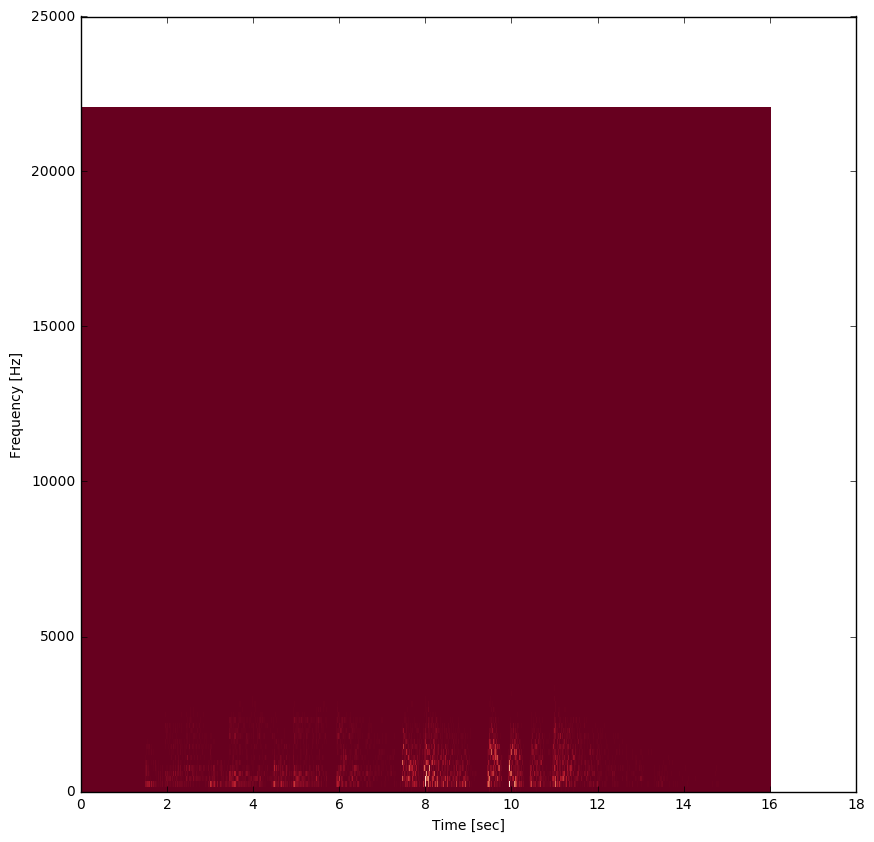

In [26]:
f, t, Sxx = spectrogram(np.absolute(samples), sample_rate)
print(f.shape)
print(t.shape)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

(129,)
[     0.          172.265625    344.53125     516.796875    689.0625
    861.328125   1033.59375    1205.859375   1378.125      1550.390625
   1722.65625    1894.921875   2067.1875     2239.453125   2411.71875
   2583.984375   2756.25       2928.515625   3100.78125    3273.046875
   3445.3125     3617.578125   3789.84375    3962.109375   4134.375
   4306.640625   4478.90625    4651.171875   4823.4375     4995.703125
   5167.96875    5340.234375   5512.5        5684.765625   5857.03125
   6029.296875   6201.5625     6373.828125   6546.09375    6718.359375
   6890.625      7062.890625   7235.15625    7407.421875   7579.6875
   7751.953125   7924.21875    8096.484375   8268.75       8441.015625
   8613.28125    8785.546875   8957.8125     9130.078125   9302.34375
   9474.609375   9646.875      9819.140625   9991.40625   10163.671875
  10335.9375    10508.203125  10680.46875   10852.734375  11025.
  11197.265625  11369.53125   11541.796875  11714.0625    11886.328125
  12058.59375  

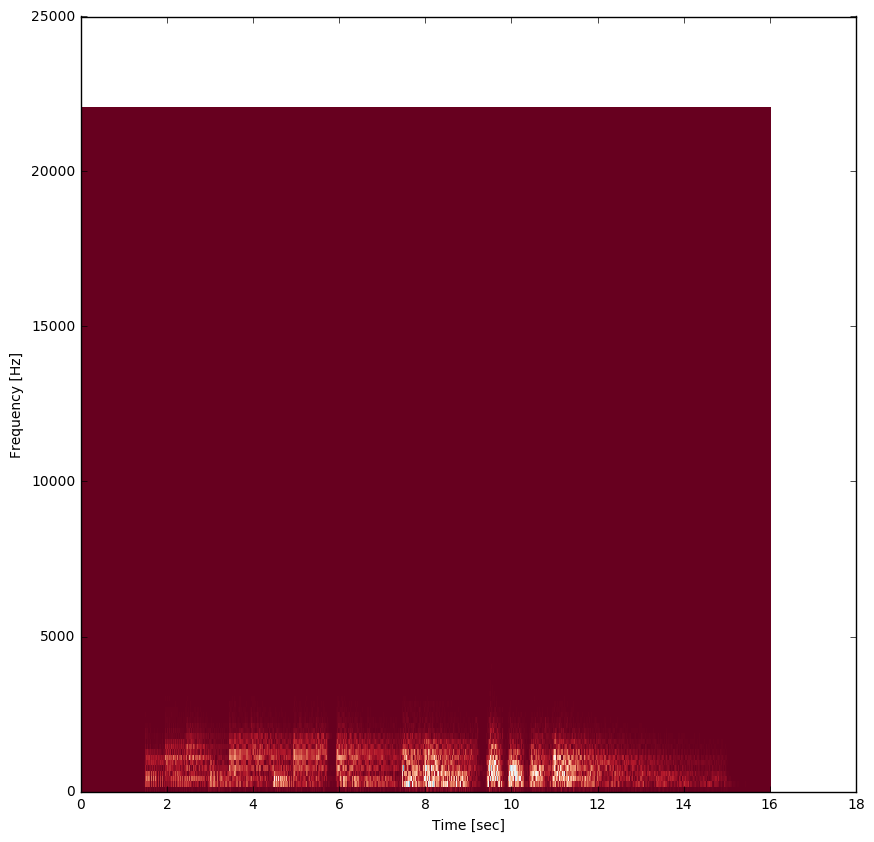

In [29]:
f, t, Sxx = spectrogram(samples, sample_rate, mode='magnitude')
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

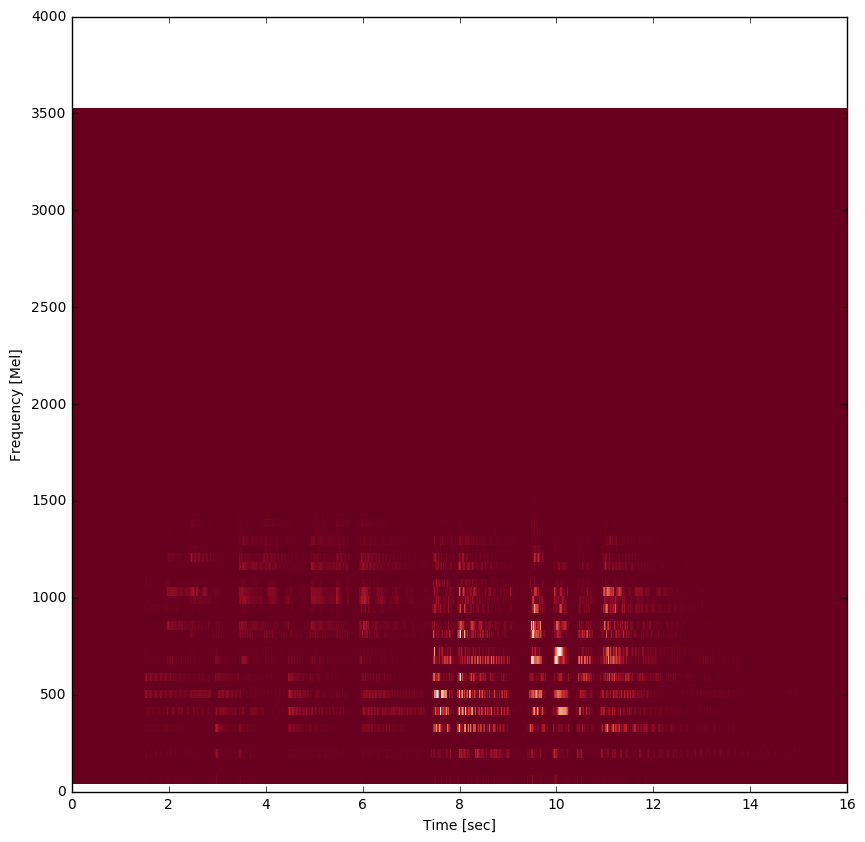

In [17]:
def to_mel(freq):
    return 1125 * math.log(1 + freq/700)

winlen = 0.046
winstep = 0.01
lowfreq = 27.5
highfreq = 16000
# features, _ = fbank(samples, sample_rate, nfilt=80)
features, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
# features = logfbank(samples, sample_rate, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
t_len, f_len = features.shape
mel_lowfreq = to_mel(lowfreq)
mel_highfreq = to_mel(highfreq)
f = np.arange(mel_lowfreq, mel_highfreq, (mel_highfreq - mel_lowfreq)/f_len)
t = np.arange(0.0, t_len*winstep, winstep)

plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, features.T, cmap='RdBu')
plt.ylabel('Frequency [Mel]')
plt.xlabel('Time [sec]')

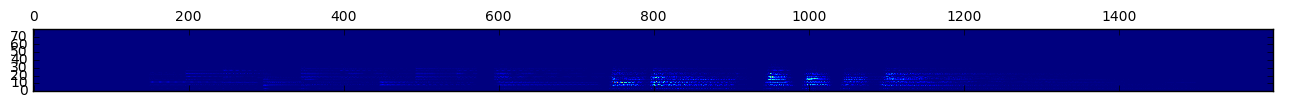

In [58]:
plt.matshow(features.T, origin='lower')

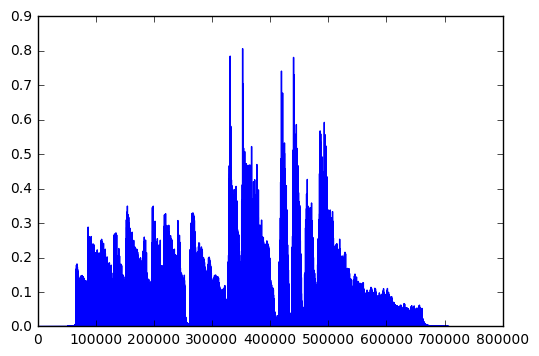

In [19]:
plt.plot(np.absolute(samples))

In [35]:
samples, sample_rate = soundfile.read(r'data\IDMT-SMT-GUITAR_V2\dataset2\audio\LP_Lick8_KN.wav')
print(samples.shape)
print(sample_rate)

(657232,)
44100


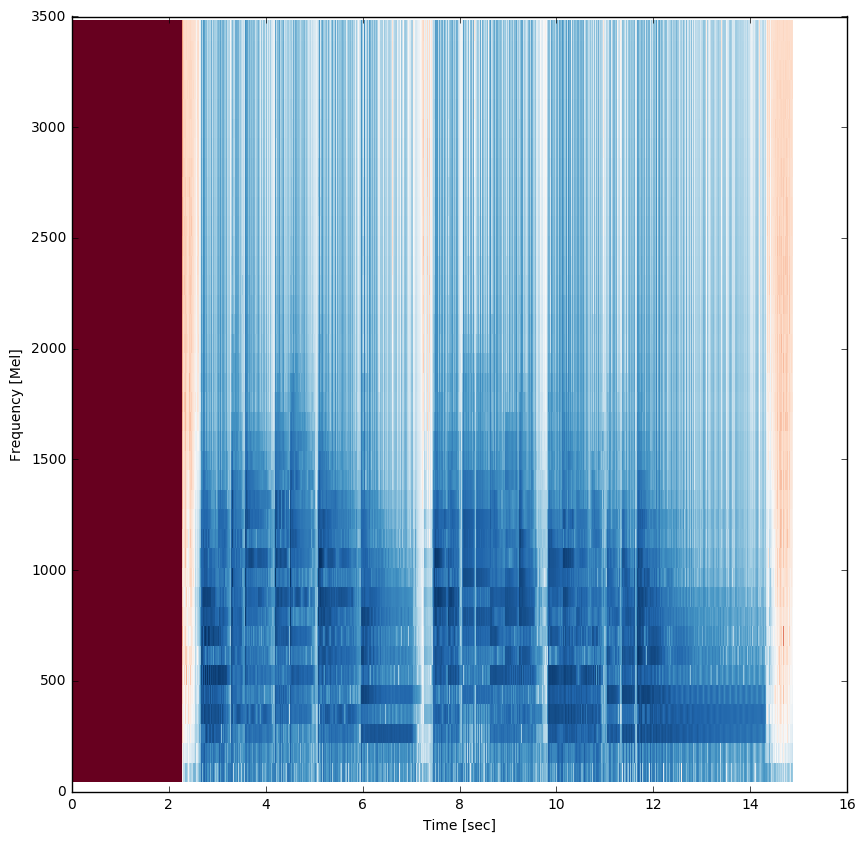

In [50]:
winlen = 0.046
winstep = 0.01
lowfreq = 27.5
highfreq = 16000
# features, _ = fbank(samples, sample_rate, nfilt=80)
# features, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=41, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
features = logfbank(samples, sample_rate, winstep=winstep, nfilt=40, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
t_len, f_len = features.shape
mel_lowfreq = to_mel(lowfreq)
mel_highfreq = to_mel(highfreq)
f = np.arange(mel_lowfreq, mel_highfreq, (mel_highfreq - mel_lowfreq)/f_len)
t = np.arange(0.0, t_len*winstep, winstep)

plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, features.T, cmap='RdBu')
plt.ylabel('Frequency [Mel]')
plt.xlabel('Time [sec]')

In [45]:
for j in range(features.shape[1]):
    print(str(j) + ' ' + str(features[:, j].mean()))

0 0.00846905107682
1 0.012509268175
2 0.109920004448
3 0.121226440889
4 2.22044604925e-16
5 0.124424883045
6 0.229177569573
7 0.167832682587
8 0.0989874644363
9 0.0760293318726
10 0.162408544505
11 0.0779480567678
12 0.125057948133
13 0.0604417465413
14 0.0279902610011
15 0.0119065347092
16 0.00505722484522
17 0.00288380917565
18 0.00180589753228
19 0.00113410473765
20 0.000742650644601
21 0.000691578039833
22 0.000510261579023
23 0.00038534596173
24 0.000356908464057
25 0.000289757144556
26 0.000242126201982
27 0.000229476285399
28 0.000235264929197
29 0.000198254305356
30 0.000181491678347
31 0.00016862104101
32 0.00014440376332
33 0.000143692758428
34 0.000132544087732
35 0.000122410588463
36 0.000113758089678
37 0.000110590088998
38 0.000102924919833
39 9.60875321525e-05
40 9.83139374522e-05
41 9.60516157077e-05


In [47]:
for j in range(features.shape[1]):
    print(str(j) + ' ' + str(features[:, j].mean()))

0 0.00846905107682
1 0.012509268175
2 0.109920004448
3 0.121226440889
4 0.124424883045
5 0.178417774877
6 0.10151958939
7 0.117072887892
8 0.0989874644363
9 0.143134764722
10 0.123500790462
11 0.105867326086
12 0.0817650518943
13 0.0476176946562
14 0.0279902610011
15 0.0119065347092
16 0.0058628537748
17 0.00283804582149
18 0.00161800356748
19 0.001031534069
20 0.000705041533134
21 0.000499324204019
22 0.000445479987077
23 0.000398975061579
24 0.000320452602069
25 0.000293064046532
26 0.000268355969962
27 0.000223720753439
28 0.000206707036796
29 0.000190167200047
30 0.000162017477958
31 0.000161561686359
32 0.000148715292673
33 0.00013572493359
34 0.000132509133194
35 0.000115403276522
36 0.000106881414547
37 0.000109093427884
38 0.000105552124339
39 9.83139374522e-05
40 9.60516157077e-05


In [2]:
active_datasets = {1, 2, 3, 4}
X_parts, y_parts, y_start_only_parts, ds_labels = read_data(active_datasets, subsampling_step=1)

D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_FN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_KN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_MN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:151: UserWarning: Skipping non-wav file data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini
  warn('Skipping non-wav file ' + path_to_wav)
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for FS_Lick11_FN.wav, skipping file.
  warn('No truth foun

In [3]:
X_parts_train, X_parts_test, y_parts_train, y_parts_test, y_start_only_parts_train, y_start_only_parts_test, ds_labels_train, ds_labels_test = train_test_split(
    X_parts, y_parts, y_start_only_parts, ds_labels, test_size=0.2, random_state=42
)

In [4]:
# TODO fbank / logfbank seem to bug starting from nfilt=42 (some filterbanks = 0)
# macht wohl eh mehr sinn, einfach nach den midi toenen zu filtern.
# TODO refactor read_data, sample_rate from file, winstep from fixed frame rate
def transform(X_part, y_part, y_start_only_part, ds_label, log_transform_magnitudes=True,
              sample_rate=44100, winlen=0.046, winstep=0.01, nfilt=40, nfft=512,
              lowfreq=27.5, highfreq=16000, preemph=0):
    """Last (winlen - winstep) seconds will be cut off"""
    
    samples = X_part.ravel()
    if log_transform_magnitudes:
        filterbank = logfbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=nfilt,
                               lowfreq=lowfreq, highfreq=highfreq, preemph=preemph)
    else:
        filterbank, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=nfilt,
                               lowfreq=lowfreq, highfreq=highfreq, preemph=preemph)
    
    n_frames = filterbank.shape[0]
    ds_labels_part = np.empty(n_frames, dtype=np.int8)
    ds_labels_part.fill(ds_label)
    return filterbank, y_part[:n_frames], y_start_only_part[:n_frames], ds_labels_part

def transform_all(X_parts, y_parts, y_start_only_parts, ds_labels):
    transformed = [transform(X_part, y_part, y_start_only_part, ds_label)
                   for X_part, y_part, y_start_only_part, ds_label
                   in zip(X_parts, y_parts, y_start_only_parts, ds_labels)]
    X = np.concatenate([my_tuple[0] for my_tuple in transformed])
    y = np.concatenate([my_tuple[1] for my_tuple in transformed])
    y_start_only = np.concatenate([my_tuple[2] for my_tuple in transformed])
    ds_labels_flat = np.concatenate([my_tuple[3] for my_tuple in transformed])
    
    return X, y, y_start_only, ds_labels_flat

X_train, y_train, y_start_only_train, ds_labels_flat_train = transform_all(
    X_parts_train, y_parts_train, y_start_only_parts_train, ds_labels_train
)
X_test, y_test, y_start_only_test, ds_labels_flat_test = transform_all(
    X_parts_test, y_parts_test, y_start_only_parts_test, ds_labels_test
)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(y_train.sum())
print(y_start_only_train.shape)
print(y_start_only_train.sum())
print(ds_labels_flat_train.shape)
print(ds_labels_flat_train.mean())

print(X_test.shape)
print(y_test.shape)
print(y_test.sum())
print(y_start_only_test.shape)
print(y_start_only_test.sum())
print(ds_labels_flat_test.shape)
print(ds_labels_flat_test.mean())

(938040, 40)
(938040,)
41181
(938040,)
19113
(938040,)
3.15195194235
(231210, 40)
(231210,)
10355
(231210,)
4847
(231210,)
3.18374205268


In [ ]:
# Standardize for each band separately
for j in range(X_train.shape[1]):
    ss = StandardScaler()
    X_train[:, j:j+1] = ss.fit_transform(X_train[:, j:j+1])
    X_test[:, j:j+1] = ss.transform(X_test[:, j:j+1])

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_train.mean())
print(X_train.std())
print(X_test.mean())
print(X_test.std())

(938040, 40)
(231210, 40)
-1.59918321579e-17
1.0
0.00815982794737
0.990272010302


In [5]:
X_parts = None
y_parts = None
y_start_only_parts = None
ds_labels = None
X_parts_train = None
X_parts_test = None
y_parts_train = None
y_parts_test = None
y_start_only_parts_train = None
y_start_only_parts_test = None
ds_labels_train = None
ds_labels_test = None